# Class Prior Estimation in Active Positive and Unlabeled Learning

In [1]:
###If you do not have installed cython, run:
#!pip install cython 

### or, in case of problems with cython, run:
#!pip install -U --force-reinstall Cython 

In [2]:
### Note that the versions used in this notebook are:
#   - Python: 3.7.5
#   - Cython: 0.29.16

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from sklearn.neighbors import KernelDensity
from multiprocessing import Pool, freeze_support, cpu_count
from anomatools.models import SSDO
from sklearn.ensemble import IsolationForest
import pyximport
pyximport.install()
from CAPe import *

def ignore_warnings():
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)

ignore_warnings()

# Generate examples

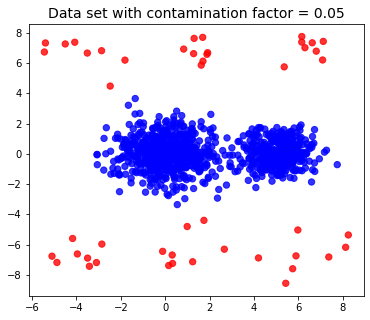

In [4]:
np.random.seed(1)
n = 1000
class_prior = 0.95 #real class prior
contamination = 1-class_prior

#Training set
a1_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a2_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a3_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a4_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a5_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a6_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
num_anom = a1_.shape[1] + a2_.shape[1]+ a3_.shape[1] + a4_.shape[1] + a5_.shape[1]+ a6_.shape[1]

d1_ = np.random.randn(2, np.int(n*0.6))*1.1
n_ = n - d1_.shape[1] - num_anom
d2_ = np.random.randn(2, n_)*0.8

d2_[0, :] += 5

a1_[0, :] += 6.5
a1_[1, :] -= 6.5
a2_[0, :] -= 4.
a2_[1, :] -= 6.5
a3_[0, :] += 1.
a3_[1, :] -= 6.5
a4_[0, :] += 6.5
a4_[1, :] += 6.5
a5_[0, :] -= 4.
a5_[1, :] += 6.5
a6_[0, :] += 1.5
a6_[1, :] += 6.5


data_set = np.concatenate((a1_, a2_, a3_, a4_,a5_, a6_, d1_, d2_), axis=1)
X_train = data_set.T
y = np.zeros(n, dtype=np.int)
y[:num_anom] = +1

#Plot training and test sets
fig = plt.figure(figsize=(6, 5), facecolor='w', edgecolor='k')
colors = np.array(['b' if y[i] == 0 else 'r' for i in range(n)])# ['g', 'r'])
plt.scatter(X_train.T[0],X_train.T[1], 40, colors, alpha = 0.8)
plt.title("Data set with contamination factor = "+str(round(1-class_prior, 2)), fontsize=14)
plt.show()

# CAPe: Class prior estimation in Active Pu lEarning

In [5]:
#Inizialize two lists for AL strategy:
query_list = []                        #List of queried examples
labeled_ex = np.zeros(n, dtype=np.int) #List of labeled examples

#Inizialize all the parameters of our model
case = 2                               #0 -> perfect oracle, 2 -> imperfect oracle
k = 10                                 #Number of labeled examples required at each step
prior = 0.9                            #First guess of the prior
real_anomalies = np.where(y == 1)[0]   #If case = 2, you can use real_anomalies = []

#Estimate the density of examples
ker = KernelDensity().fit(X_train)
dmu = [np.exp(ker.score(X_train[i:i+1])) for i in range(n)]
mean_prob_term = math.log(np.mean(dmu),10) #Take the log density

### How to run CAPe with a single iteration

In [6]:
prior, labeled_ex, query_list, propensity_score = CAPe(X_train, labeled_ex, query_list, k, real_anomalies,
                                                       1-prior, mean_prob_term, case)
print("Estimated prior with k =", k, "labels:", prior)

Estimated prior with k = 10 labels: 0.8472800254821777


### How to run CAPe in a for loop querying labels with *Perfect User*

In [7]:
prior = 0.9
ntimes = 20 #number of total iterations
k = 10
case = 0                               #0 -> perfect oracle, 2 -> imperfect oracle
query_list = []                        #List of queried examples
labeled_ex = np.zeros(n, dtype=np.int) #List of labeled examples

perf_user_priors = np.zeros(ntimes, dtype= np.float)

for t in range(ntimes):
    prior, labeled_ex, query_list, _ = CAPe(X_train, labeled_ex, query_list, k, real_anomalies,
                                            1-prior, mean_prob_term, case)
    perf_user_priors[t] = prior
    print("Iteration:",t,"prior:", prior)

Iteration: 0 prior: 0.8473305702209473
Iteration: 1 prior: 0.8324727416038513
Iteration: 2 prior: 0.8392828702926636
Iteration: 3 prior: 0.8497931361198425
Iteration: 4 prior: 0.8585575819015503
Iteration: 5 prior: 0.8703089356422424
Iteration: 6 prior: 0.8794957399368286
Iteration: 7 prior: 0.8874824643135071
Iteration: 8 prior: 0.895491361618042
Iteration: 9 prior: 0.9051927328109741
Iteration: 10 prior: 0.9132745265960693
Iteration: 11 prior: 0.9194993376731873
Iteration: 12 prior: 0.9258894324302673
Iteration: 13 prior: 0.9310635924339294
Iteration: 14 prior: 0.9370702505111694
Iteration: 15 prior: 0.9450006484985352
Iteration: 16 prior: 0.9520033597946167
Iteration: 17 prior: 0.9520083069801331
Iteration: 18 prior: 0.9520082473754883
Iteration: 19 prior: 0.9520082473754883


### How to run CAPe in a for loop querying labels with *Imperfect User*

In [8]:
prior = 0.9
ntimes = 20 #number of total iterations
k = 10
case = 2                               #0 -> perfect oracle, 2 -> imperfect oracle
query_list = []                        #List of queried examples
labeled_ex = np.zeros(n, dtype=np.int) #List of labeled examples

imperf_user_priors = np.zeros(ntimes, dtype= np.float)

for t in range(ntimes):
    prior, labeled_ex, query_list, _ = CAPe(X_train, labeled_ex, query_list, k, real_anomalies,
                                            1-prior, mean_prob_term, case)
    imperf_user_priors[t] = prior
    print("Iteration:",t,"prior:", prior)

Iteration: 0 prior: 0.8479523658752441
Iteration: 1 prior: 0.8338090777397156
Iteration: 2 prior: 0.840290904045105
Iteration: 3 prior: 0.8506420850753784
Iteration: 4 prior: 0.8602253794670105
Iteration: 5 prior: 0.8702148199081421
Iteration: 6 prior: 0.87998366355896
Iteration: 7 prior: 0.8869045376777649
Iteration: 8 prior: 0.8919018507003784
Iteration: 9 prior: 0.89781653881073
Iteration: 10 prior: 0.9002189636230469
Iteration: 11 prior: 0.9006712436676025
Iteration: 12 prior: 0.9006205797195435
Iteration: 13 prior: 0.9004714488983154
Iteration: 14 prior: 0.9003996849060059
Iteration: 15 prior: 0.9003084897994995
Iteration: 16 prior: 0.9002290964126587
Iteration: 17 prior: 0.9001372456550598
Iteration: 18 prior: 0.9000816941261292
Iteration: 19 prior: 0.9000144004821777


### Final class prior results by using CAPe

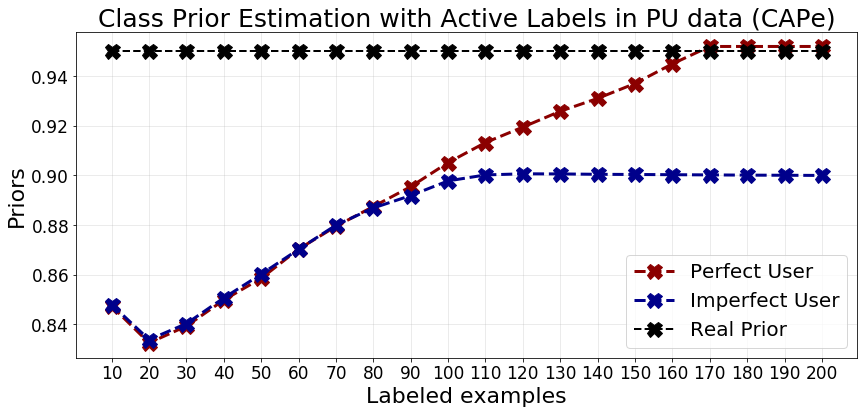

In [36]:
fig = plt.figure(figsize=(14, 6), facecolor='w', edgecolor='k')
real_prior = [class_prior for x in range(ntimes)]
ms = 15
plt.plot(np.arange(ntimes), perf_user_priors, '--X', lw = 3, c = 'darkred', 
         label = 'Perfect User', markersize = ms)
plt.plot(np.arange(ntimes), imperf_user_priors,'--X', lw = 3, c = 'darkblue', 
         label = 'Imperfect User', markersize = ms)
plt.plot(np.arange(ntimes), real_prior, '--X', lw = 2, c = 'black', label = 'Real Prior', markersize = ms)
plt.legend(fontsize = 20)
plt.xticks(np.arange(ntimes), np.arange(1,ntimes+1)*k, fontsize = 17)
plt.yticks(fontsize = 17)
plt.xlabel('Labeled examples', fontsize = 22)
plt.ylabel('Priors', fontsize = 22)
plt.title('Class Prior Estimation with Active Labels in PU data (CAPe)', fontsize = 25)
plt.grid(alpha = 0.3)
plt.show()